In [16]:
# Dependencies
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
from scipy.stats import norm  # Import for normal distribution function
import math
import seaborn as sns  # Import for heatmap plotting
from sklearn.manifold import MDS


In [3]:
from google.colab import drive

# Mount Google Drive (if not already mounted)
try:
  drive.mount('/content/drive')
except FileExistsError:
  print("Drive already mounted!")

data_path = '/content/drive/MyDrive/Spring 2024/Statistics/Genome-DataScience/hic_part2/chr19_chr20.txt'

# Read the data
df = pd.read_csv(data_path, delim_whitespace=True, header=None)
df.columns = ["position1", "position2", "interaction frequency"]
df[['position1', 'position2']] /= 250000

# Apply log1p transformation
df["interaction frequency"] = np.log1p(df["interaction frequency"])

# Pivot the DataFrame to create the heatmap structure
interaction_matrix = df.pivot_table(
    values="interaction frequency", index="position1", columns="position2"
)
interaction_matrix = interaction_matrix.values

print("Data loaded and processed successfully!")


Mounted at /content/drive
Data loaded and processed successfully!


In [4]:
# Helper functions

def calculate_p_value(submatrix):
    submatrix_mean = np.mean(submatrix)
    k = submatrix.shape[0]
    l = submatrix.shape[1]
    kl =  math.sqrt(k * l)
    mean = 1.1310316340515036
    std_dev = 0.402034528977477
    z_score = ((submatrix_mean - mean) * kl / std_dev)
    p_value = (1 - norm.cdf(z_score)) * tot_pos_submatrices(submatrix)
    if math.isnan(p_value):
        return np.inf
    return p_value

def tot_pos_submatrices(submatrix):
  submatrix_count = 0
  m,n = submatrix.shape[0], submatrix.shape[1]
  for i in range(m):
      for j in range(i, m):
          for k in range(n):
              for l in range(k, n):
                  # Increment counter for each valid submatrix
                  submatrix_count += 1
  return submatrix_count

In [9]:
def greedy_search(interaction_matrix):
    """
  Performs a greedy search to identify a submatrix with low p-value.

  Args:
      interaction_matrix: The interaction matrix as a NumPy array.
      max_iterations: Maximum number of iterations for the search (optional).

  Returns:
      A tuple containing the best submatrix (as a NumPy array) and its p-value.
    """
    continue_flag = False
    while continue_flag == False:
        m_rows = int(df['position1'].iloc[-1])
        n_cols = int(df['position2'].iloc[-1])

        random_row = np.random.randint(0, m_rows-1)
        random_col = np.random.randint(0, n_cols-1)
        random_row_u, random_row_d = random_row, random_row+1
        random_col_l, random_col_r = random_col, random_col+1

        initial_submatrix = interaction_matrix[random_row_u: random_row_d, random_col_l: random_col_r]  # Select single value
        if initial_submatrix == []:
            continue
        if initial_submatrix.size == 0:
            continue

        if not math.isnan(initial_submatrix[0]):
            if initial_submatrix[0][0] > 0:
                current_submatrix = initial_submatrix  # Convert to 1x1 NumPy array
                continue_flag = True
            else:
                continue
        else:
            continue
    current_p_value = calculate_p_value(current_submatrix) # Calculate P Value for me

  # Step 2: Main loop: break when P value can no longer decrease
    while True:
        # Initialize variables for storing p-values
        up_p_value, down_p_value, left_p_value, right_p_value = np.inf, np.inf, np.inf, np.inf
        # Step 2a: directional expansion
        total_possible_submatrices = tot_pos_submatrices(current_submatrix)
        for dir in ["u", "d", "l", "r"]:
            if dir == "u":
                if random_row_u == 0:
                    continue
                up_expanded_submatrix = interaction_matrix[random_row_u - 1: random_row_d, random_col_l: random_col_r]
                up_p_value = calculate_p_value(up_expanded_submatrix)

            # Downward expansion
            if dir == "d":
                if random_row_d == m_rows:
                    continue
                down_expanded_submatrix = interaction_matrix[random_row_u: random_row_d + 1, random_col_l: random_col_r]
                down_p_value = calculate_p_value(down_expanded_submatrix)
            # Leftward expansion
            if dir == "l":
                if random_col_l == 0:
                    continue
                left_expanded_submatrix = interaction_matrix[random_row_u: random_row_d, random_col_l-1: random_col_r]
                left_p_value = calculate_p_value(left_expanded_submatrix)

            # Rightward expansion
            if dir == "r":
                if random_col_r == n_cols:
                    continue
                right_expanded_submatrix = interaction_matrix[random_row_u: random_row_d, random_col_l: random_col_r+1]
                right_p_value = calculate_p_value(right_expanded_submatrix)

        # Check for all increases in p-value
        if up_p_value >= current_p_value and down_p_value >= current_p_value and left_p_value >= current_p_value and right_p_value >= current_p_value:
            adjusted_p_value = current_p_value * total_possible_submatrices
            return current_submatrix, current_p_value, (random_row_u, random_row_d, random_col_l, random_col_r)
            break  # Stop if all expansions lead to p-value increases

        # Choose direction with smallest p-value and update submatrix
        best_expansion_p_value = min(up_p_value, down_p_value, left_p_value, right_p_value)

        if best_expansion_p_value == up_p_value:
            current_submatrix = up_expanded_submatrix
            random_row_u -=1
        elif best_expansion_p_value == down_p_value:
            current_submatrix = down_expanded_submatrix
            random_row_d += 1
        elif best_expansion_p_value == left_p_value:
            current_submatrix = left_expanded_submatrix
            random_col_l -= 1
        elif best_expansion_p_value == right_p_value:
            current_submatrix = right_expanded_submatrix
            random_col_r += 1
        current_p_value = best_expansion_p_value

In [12]:

def identify_interaction_regions(interaction_matrix, p_value_threshold=0.01, num_iterations=1000):
  """
  Identifies interaction regions in a transformed interaction matrix using greedy search.

  Args:
      interaction_matrix: The interaction matrix as a NumPy array.
      p_value_threshold: Threshold for p-value to consider a region significant (default: 0.01).
      num_iterations: Number of times to run the greedy search (default: 100).

  Returns:
      A list of identified interaction regions (submatrices) and their corresponding p-values.
  """
  identified_regions = []

  # Update interaction matrix copy for subtraction
  working_matrix = interaction_matrix.copy()
  for i in range(num_iterations):
    submatrix, p_value, global_coords = greedy_search(working_matrix)
    # Check if p-value is below threshold (significant interaction)
    if p_value <= p_value_threshold:
      identified_regions.append(global_coords)
      submatrix_mean = np.mean(submatrix)
      working_matrix[global_coords[0]: global_coords[1], global_coords[2]: global_coords[3]] -= submatrix_mean
    else:
      # No more significant interactions found
      continue
  return identified_regions


def plot_heatmap_with_regions(interaction_matrix, identified_regions):
    """
  Plots a heatmap of the interaction matrix highlighting identified regions.

  Args:
      interaction_matrix: The interaction matrix as a NumPy array.
      identified_regions: A list of tuples containing identified submatrices and their p-values.
    """
    fig, ax = plt.subplots(figsize=(10, 10))

    sns.color_palette("mako", as_cmap=True)
  # 1. Plot the heatmap itself
    sns.heatmap(
      interaction_matrix, cmap="hot",  # Emphasize lower p-values
      center=0,  # Adjust center for data distribution
      square=True, linewidths=0.5, cbar_kws={"label": "Interaction Frequency"}
  )

  # 2. Overlay highlighted regions
    for gc in identified_regions:
        row_start, row_end = gc[0], gc[1]
        col_start, col_end = gc[2], gc[3]
        ax.fill_between(
            [col_start, col_end], [row_start, row_start],[row_end, row_end], color='red', alpha=0.2, zorder=10
        )  # Red overlay for identified regions

    '''
        ax.fill_between(50, 80, 50, 80, color = 'red', alpha = 0.2, zorder = 10)
        '''
    plt.show()



<ipython-input-9-6b18b900aa57>:23: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if initial_submatrix == []:
<ipython-input-9-6b18b900aa57>:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  if not math.isnan(initial_submatrix[0]):


Identified regions =  [(70, 76, 129, 133), (17, 21, 129, 138), (117, 120, 50, 55), (129, 132, 86, 87), (215, 220, 202, 208), (101, 102, 94, 101), (214, 220, 60, 65), (171, 182, 110, 119), (81, 83, 59, 61), (194, 196, 140, 147), (171, 178, 130, 136), (13, 18, 120, 124), (178, 182, 123, 128), (116, 119, 220, 223), (164, 177, 12, 17), (169, 174, 126, 130), (86, 92, 152, 156), (110, 120, 210, 216), (114, 118, 47, 48), (91, 96, 207, 208), (66, 70, 124, 134), (122, 128, 211, 216), (111, 115, 220, 223), (178, 183, 128, 134), (80, 81, 50, 51), (42, 47, 181, 187), (19, 24, 110, 119), (101, 102, 21, 22), (128, 136, 240, 241), (5, 9, 127, 132), (71, 74, 234, 238), (101, 103, 75, 76), (117, 118, 101, 105), (209, 211, 63, 68), (19, 22, 235, 238), (50, 56, 234, 240), (104, 106, 202, 204), (52, 58, 119, 128), (129, 131, 57, 59), (120, 127, 93, 99), (2, 12, 182, 186), (105, 108, 63, 64), (80, 84, 203, 208), (106, 110, 221, 223), (104, 109, 3, 4), (5, 8, 238, 241), (118, 120, 82, 85), (68, 79, 109, 117

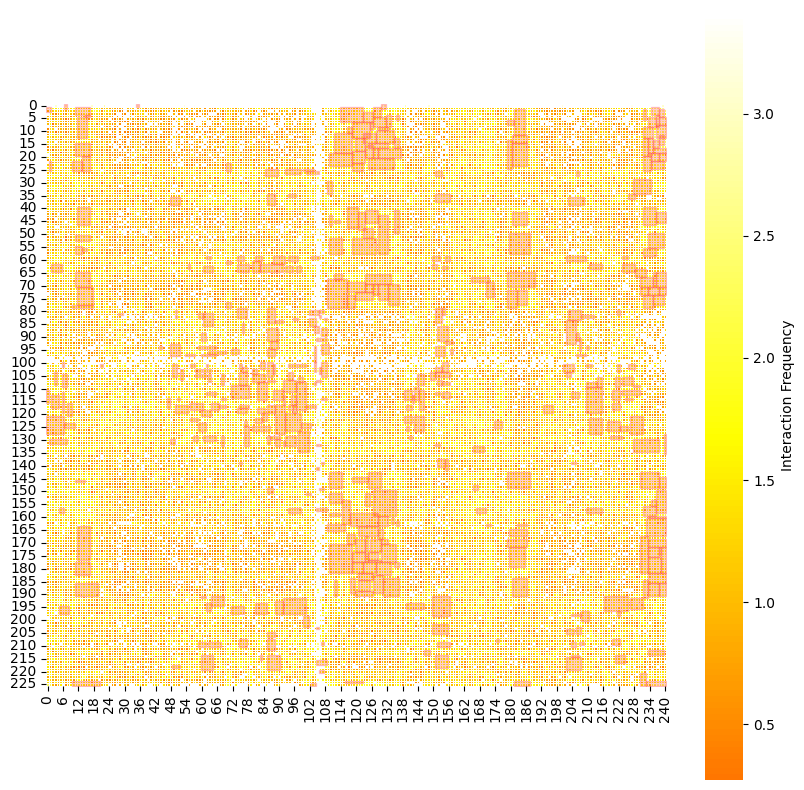

In [13]:
identified_regions = identify_interaction_regions(interaction_matrix, p_value_threshold=0.01, num_iterations=10000)
print("Identified regions = ", identified_regions)
plot_heatmap_with_regions(interaction_matrix, identified_regions)

In [19]:
import warnings
warnings.simplefilter(action='ignore', category=DeprecationWarning)

def analyze_chromosome_interaction():
    interaction_counts = np.zeros((22, 22))  # Initialize empty matrix for interaction counts

    # Absolute paths to your folders
    folder1_path = '/content/drive/MyDrive/Spring 2024/Statistics/Genome-DataScience/hic_part1'
    folder2_path = '/content/drive/MyDrive/Spring 2024/Statistics/Genome-DataScience/hic_part2'

    folders = [folder1_path, folder2_path]

    for folder in folders:
        for filename in os.listdir(folder):
            file_path = os.path.join(folder, filename)

            chr1, chr2 = file_path.split("/")[-1].split(".")[0].split("_")
            chr1, chr2 = int(chr1[3:]), int(chr2[3:])

            # Read data, preprocess, and create heatmap structure
            df = pd.read_csv(file_path, delim_whitespace=True, header=None)
            df.columns = ["position1", "position2", "interaction frequency"]
            df[['position1', 'position2']] /= 250000
            df["interaction frequency"] = np.log1p(df["interaction frequency"])
            interaction_matrix = df.pivot_table(
                values="interaction frequency", index="position1", columns="position2"
            )
            interaction_matrix = interaction_matrix.values
            identified_regions = identify_interaction_regions(interaction_matrix)

            '''
            for gc in identified_regions:
                row_start, row_end = gc[0], gc[1]
                col_start, col_end = gc[2], gc[3]

            # Count interactions within this region
            interaction_counts[chr1 - 1, chr2 - 1] += np.sum(
                interaction_matrix[row_start:row_end + 1, col_start:col_end + 1]
            )
            '''
            interaction_counts[chr1 - 1, chr2 - 1] += len(identified_regions)

    return interaction_counts


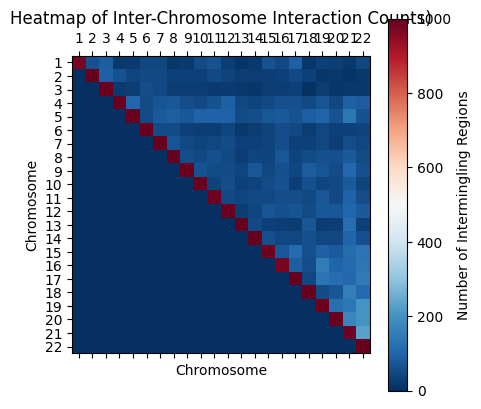

In [20]:
interaction_counts = analyze_chromosome_interaction()

plt.matshow(interaction_counts, cmap="RdBu_r")
plt.colorbar(label="Number of Intermingling Regions")

# Set axis labels
plt.xticks(range(22), [str(i + 1) for i in range(22)])
plt.yticks(range(22), [str(i + 1) for i in range(22)])

# Add labels and title
plt.xlabel("Chromosome")
plt.ylabel("Chromosome")
plt.title("Heatmap of Inter-Chromosome Interaction Counts)")
plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_mds.py:601: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(
<ipython-input-21-b85d8464e3ae>:13: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(embedding[0], embedding[1], embedding[2], c=color, label=f"Chromosome {i+1}")


Chromosome Embeddings =  [[ -81.09555987  532.38285358 -739.39011504]
 [ 634.23035416  624.28023462 -365.13252044]
 [-653.68641721  244.80316182 -646.13087787]
 [-877.38495368  196.6857857   143.17790832]
 [-596.08262285  674.60600643  -19.83828357]
 [ -94.35670856  791.07163002  506.56820043]
 [  20.731528    904.71085563 -179.97745004]
 [ 511.04025529   82.82463251 -762.21503787]
 [-814.58361239 -391.21000319 -124.97874027]
 [-496.01354494  256.39897697  738.64620786]
 [ -76.51878882 -197.06985395 -866.81676048]
 [ 565.81866114  593.10139972  333.79384544]
 [ 863.9417959    22.40816757  405.12573355]
 [-435.75650249 -609.30224691 -552.34833497]
 [ 270.2385113   196.52356415  828.6299918 ]
 [ 807.40701253 -182.68449134 -217.97816799]
 [ 429.43423571 -649.43407229 -476.97691822]
 [-614.71264205 -451.64871851  534.60218631]
 [ -36.52521218 -898.60123094  -90.6425178 ]
 [ 604.51301783 -655.40068618  282.71236238]
 [ -40.14521091 -725.48628998  458.57842718]
 [ 109.50640409 -358.95967542 

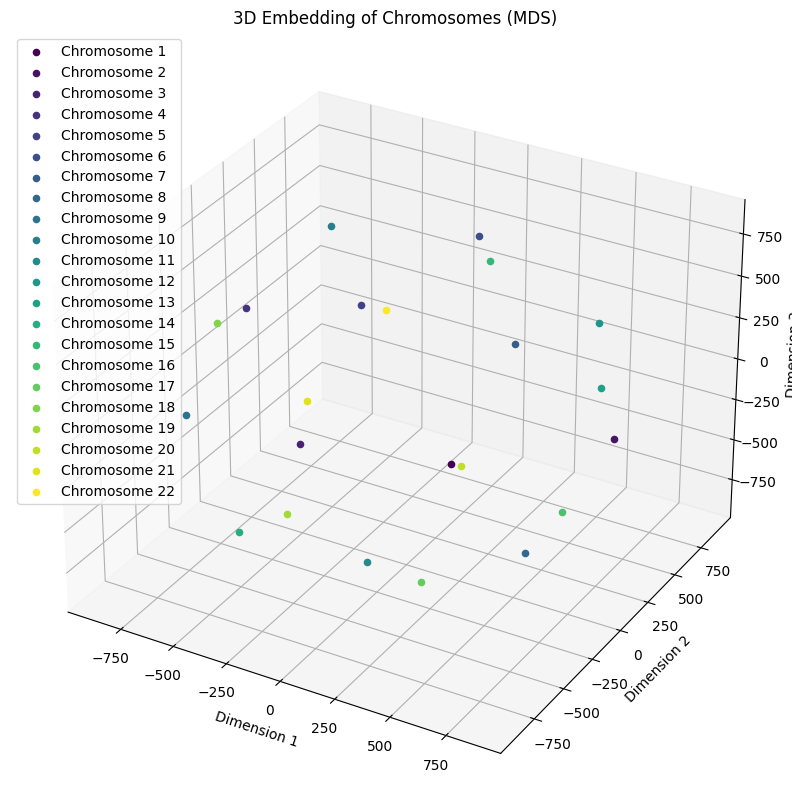

In [21]:
mds = MDS(n_components=3)
chromosome_embeddings = mds.fit_transform(interaction_counts)
print("Chromosome Embeddings = ", chromosome_embeddings)

colors = plt.cm.viridis(np.linspace(0, 1, len(chromosome_embeddings)))

# Create the 3D scatter plot
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

for i, (embedding, color) in enumerate(zip(chromosome_embeddings, colors)):
  # Plot each chromosome with its corresponding color
  ax.scatter(embedding[0], embedding[1], embedding[2], c=color, label=f"Chromosome {i+1}")

ax.set_xlabel("Dimension 1")
ax.set_ylabel("Dimension 2")
ax.set_zlabel("Dimension 3")
ax.set_title("3D Embedding of Chromosomes (MDS)")
plt.legend()
plt.show()